<a href="https://colab.research.google.com/github/mschoder/sugarcane-weed-classification/blob/master/preprocessing/dataset_rotation_resize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pathlib
import shutil
import cv2
import json
import os, copy
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [3]:
# Install gcsfuse to access gcp bucket directly
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

# Log in for GCP bucket access
from google.colab import auth
auth.authenticate_user()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   653  100   653    0     0  16325      0 --:--:-- --:--:-- --:--:-- 16743
OK
40 packages can be upgraded. Run 'apt list --upgradable' to see them.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 40 not upgraded.
Need to get 10.7 MB of archives.
After this operation, 22.9 MB of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 144786 files and directories currently installed.)
Preparing to unpack .../gcsfuse_0.32.0_amd64.deb ...
Unpacking gcsfuse (0.32.0) ...
Setting up gcsfuse (0.32.0) ...


In [4]:
# Connect to gcp data bucket
!mkdir data
!gcsfuse --implicit-dirs crop-weed-bucket data 

# Verify acces
!ls data/

Using mount point: /content/data
Opening GCS connection...
Mounting file system...
File system has been successfully mounted.
allweeds_1200x800  bounding_boxes	raw_images
allweeds_600x400   jpg_images_allweeds


In [ ]:
# !rm -rf data/allweeds_1200x800/
# !mkdir data/allweeds_600x400

In [ ]:
data_dir = pathlib.Path('data/jpg_images_allweeds/')
weed_labels_path = 'data/jpg_images_allweeds/weed_labels.json'
out_dir = pathlib.Path('data/allweeds_600x400/')
raw_list = sorted(list(data_dir.glob('*.jpg')))

with open(weed_labels_path) as annot_file:
    annot_dict = json.load(annot_file)

new_annot_dict = copy.deepcopy(annot_dict)


for ct,f in enumerate(raw_list):
    if ct%10 == 0:
        print(ct, " Images Processed / ", len(raw_list))
    # open image
    img = cv2.imread(str(f))
    
    h, w, _ = img.shape
    # check whether image needs to be rotated
    if h > w:
        # rotate img 90 CCW (0->1 axis direction)
        img = np.rot90(img)
        h, w, _ = img.shape

        # rotate bounding box annotations
        for idx, r in enumerate(annot_dict[f.name]['regions']):
            sa = r['shape_attributes']
            new_annot_dict[f.name]['regions'][idx]['shape_attributes']['height'] = sa['width']
            new_annot_dict[f.name]['regions'][idx]['shape_attributes']['width'] = sa['height']
            new_annot_dict[f.name]['regions'][idx]['shape_attributes']['x'] = sa['y']
            new_annot_dict[f.name]['regions'][idx]['shape_attributes']['y'] = h - sa['x'] - sa['width']
            
    ### RESIZE ###
    # resize image
    img = cv2.resize(img, (600, 400))

    # resize bbox
    for idx in range(len(annot_dict[f.name]['regions'])):
        hn, wn, _ = img.shape
        h_scale = hn / h
        w_scale = wn / w
        new_annot_dict[f.name]['regions'][idx]['shape_attributes']['height'] *= h_scale
        new_annot_dict[f.name]['regions'][idx]['shape_attributes']['width'] *= w_scale
        new_annot_dict[f.name]['regions'][idx]['shape_attributes']['x'] *= w_scale
        new_annot_dict[f.name]['regions'][idx]['shape_attributes']['y'] *= h_scale

    # save out to new dir
    cv2.imwrite(os.path.join(out_dir, f.name), img)

# save json annotations
with open(os.path.join(out_dir, "_weed_labels.json"), "w") as outfile:  
    json.dump(new_annot_dict, outfile)


0  Images Processed /  285
10  Images Processed /  285
20  Images Processed /  285
30  Images Processed /  285
40  Images Processed /  285
50  Images Processed /  285
60  Images Processed /  285
70  Images Processed /  285
80  Images Processed /  285
90  Images Processed /  285
100  Images Processed /  285
110  Images Processed /  285
120  Images Processed /  285
130  Images Processed /  285
140  Images Processed /  285
150  Images Processed /  285
160  Images Processed /  285
170  Images Processed /  285
180  Images Processed /  285
190  Images Processed /  285
200  Images Processed /  285


In [ ]:
import os
from PIL import Image, ExifTags
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [ ]:
iff = 'i3184.jpg'
kan = new_annot_dict[iff]
print(kan)

pth = 'data/allweeds_1200x800/' + iff
img_raw = cv2.imread(pth)
print("image shape: ", img_raw.shape)

fig,ax = plt.subplots(1, figsize=(15,15))
plt.imshow(img_raw)
for i in range(len(kan['regions'])):
#     if i != 1: continue
    x = kan['regions'][i]['shape_attributes']['x']
    y = kan['regions'][i]['shape_attributes']['y']
    wd = kan['regions'][i]['shape_attributes']['width']
    ht = kan['regions'][i]['shape_attributes']['height']
    # print("x: ", x)
    # print("y: ", y)
    # print("xmax: ", x+wd)
    # print("ymax: ", y+ht)
    plt.plot([x], [y], 'bo')

    rect = patches.Rectangle((x,y), wd, ht, linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

In [ ]:
iff = 'i3184.jpg'
kan = annot_dict[iff]
print(kan)

pth = 'data/jpg_images_allweeds/' + iff
img_raw = cv2.imread(pth)
print("image shape: ", img_raw.shape)



fig,ax = plt.subplots(1, figsize=(10,10))
plt.imshow(img_raw)
for i in range(len(kan['regions'])):
    # if i != 3: continue
    print(kan['regions'][i]['shape_attributes'])
    x = kan['regions'][i]['shape_attributes']['x']
    y = kan['regions'][i]['shape_attributes']['y']
    wd = kan['regions'][i]['shape_attributes']['width']
    ht = kan['regions'][i]['shape_attributes']['height']
    # print("x: ", x)
    # print("y: ", y)
    # print("xmax: ", x+wd)
    # print("ymax: ", y+ht)
    plt.plot([x], [y], 'bo')
    
    
    rect = patches.Rectangle((x,y), wd, ht, linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

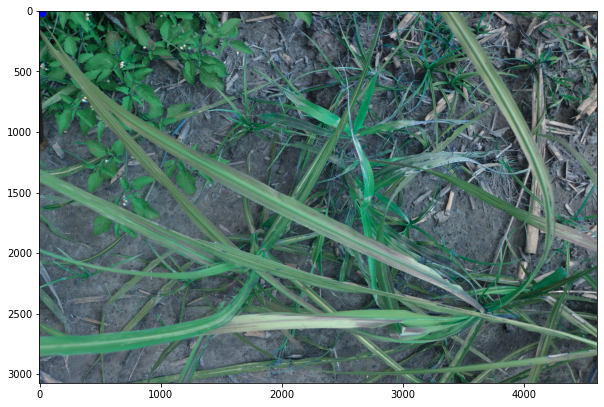

In [ ]:
img_rot = np.rot90(img_raw)

fig,ax = plt.subplots(1, figsize=(10,10))
plt.imshow(img_rot)
plt.plot([3072 - 2182 - 872],[18], 'bo')